# Segmentez des clients d'un site e-commerce

Dans ce notebook on va :
- Réduire les dimensions de notre tableau,
- Afficher le cluster
- Faire une ARI.

## Sommaire :
* [1. Importation des librairies](#chapter1)
* [2. Ouverture des fichiers](#chapter2)
* [3. Calcul de clusters avec 3 variables](#chapter3)
    * [3.1 ACP](#section_3_1)
    * [3.2 Cluster](#section_3_2)
* [4. Calcul de clusters avec 5 variables](#chapter4)
    * [4.1 Création de nouvelles variables](#section_4_1)
    * [4.2 ACP](#section_4_2)
    * [4.3 Cluster](#section_4_3)
    * [4.4 t-SNE et DBSCAN](#section_4_4)
* [5. ARI](#chapter5)
* [6. Conclusion](#chapter6)

## 1. Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
# Librairies de bases
import pandas as pd
import numpy as np

# Graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Clusters
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ACP
from sklearn.decomposition import PCA

# Date
from datetime import timedelta
from datetime import datetime

# Distance haversine
from haversine import haversine

# Mes fonctions
from P5_05_function import *

# ARI
from sklearn.metrics import adjusted_rand_score

# t-SNE
from sklearn.manifold import TSNE
from sklearn import manifold

# DBSCAN
from sklearn.cluster import DBSCAN

## 2. Ouverture des fichiers <a class="anchor" id="chapter2"></a>

In [2]:
data = pd.read_csv("notebooksimulation.csv")
data.head(3)

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,3ef8c1513fc80fb905ccd8d57da5e9b8,sao paulo,-23.545621,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.639292,books_technical,2018-08-21 17:51:40.000000000,2018-08-18 03:09:46.000000000,61.0,1.0,33.34,5,1,1,511,new customers
1,cb382a3e0fbce8a1d31e86f807314dc8,sao paulo,-23.640619,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.696566,books_technical,2018-08-21 18:12:52.000000000,2018-08-18 02:49:48.000000000,61.0,1.0,33.34,5,1,1,511,new customers
2,40b5e9eed4db7f956359145971056f5d,sao paulo,-23.738264,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.701857,books_technical,2018-08-16 21:38:54.000000000,2018-08-14 04:30:21.000000000,64.0,1.0,33.34,5,1,1,511,new customers


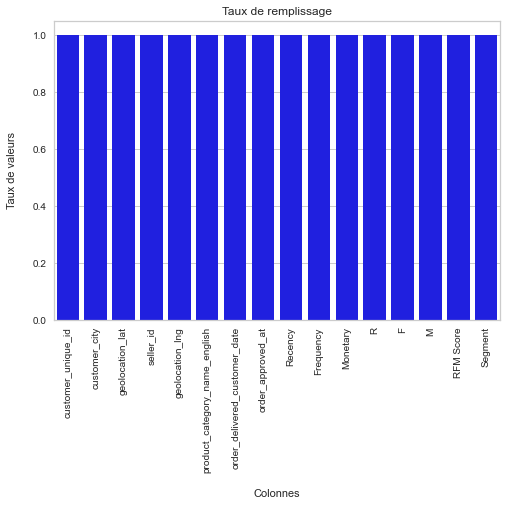

In [3]:
graphRemplissage(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             99441 non-null  object 
 1   customer_city                  99441 non-null  object 
 2   geolocation_lat                99441 non-null  float64
 3   seller_id                      99441 non-null  object 
 4   geolocation_lng                99441 non-null  float64
 5   product_category_name_english  99441 non-null  object 
 6   order_delivered_customer_date  99441 non-null  object 
 7   order_approved_at              99441 non-null  object 
 8   Recency                        99441 non-null  float64
 9   Frequency                      99441 non-null  float64
 10  Monetary                       99441 non-null  float64
 11  R                              99441 non-null  int64  
 12  F                              99441 non-null 

## 3. Calcul de cluster avec 3 variables <a class="anchor" id="chapter3"></a>

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en deux dimensions et diminuer notre temps de calcul.

### 3.1 ACP <a class="anchor" id="section_3_1"></a>

Visualisation de nos données : "Recency","Frequency" et "Monetary", il faudra standardiser nos données, nous passerons nos variables aux logarithmes. On utilise la technique "log1p" au lieu du "log" pour éviter les valeurs "- inf".

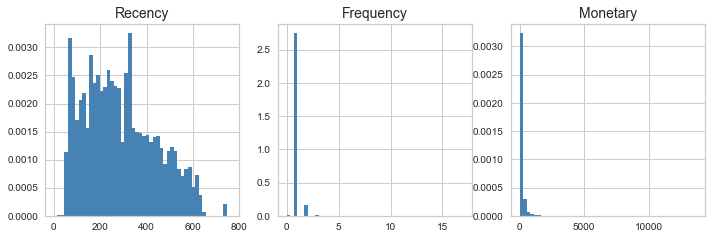

In [5]:
var = data[["Recency","Frequency", "Monetary"]]
val = var.values

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(var.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(val[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var.columns[feat_idx], fontsize=14)

In [6]:
df = data[["customer_unique_id", "Recency", "Frequency", "Monetary"]].copy()
df.set_index("customer_unique_id", inplace=True)
df = np.log1p(df[["Recency", "Frequency", "Monetary"]])

In [7]:
scaler = StandardScaler()

scaler.fit(df)
df_norm = scaler.transform(df)

On va réduire nos dimensions de notre tableau à 2 dimensions.

In [8]:
n_comp = 2 #Nombre de dimension
pca = PCA(n_components = n_comp)
features = df.columns
df_pca = pca.fit_transform(df_norm)
pcs = pca.components_

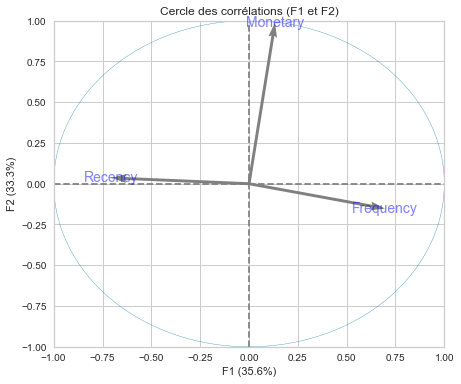

In [9]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

La variable "Frequence" est anti-corrélée à la variable "Recency". "Frequence" n'est pas du tout corrélée à la variable "Monetary".

## 3.2 Clusters <a class="anchor" id="section_3_2"></a>

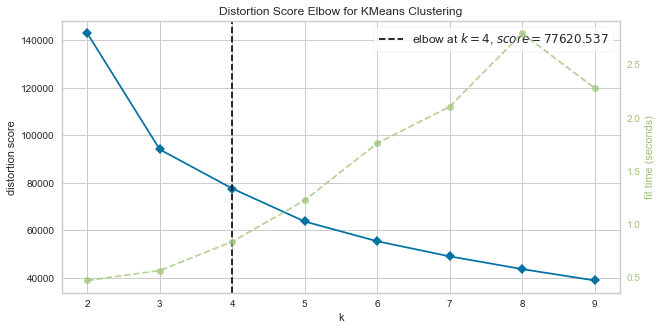

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
model = KMeans()
plt.rcParams["figure.figsize"] = (10,5)
visualizer = KElbowVisualizer(model, k =(2, 10))
visualizer.fit(df_pca)
visualizer.show()

Avec la méthode du coude, le nombre de clusters idéal est de 4.

Text(0.5, 1.0, 'Représentation des clusters du K-Means')

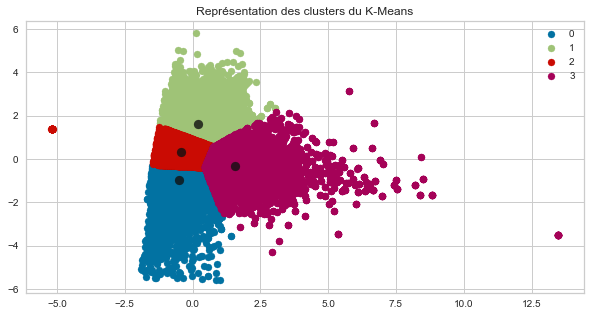

In [11]:
km = KMeans(n_clusters = 4)
label = km.fit_predict(df_pca)

centroids = km.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')

Avec le graphique de l'ACP, on peut analyser notre cluster. La fréquence part vers la droite, comme on sait qu'un client n'achète qu'une fois. La récence est basse, et sur l'ACP, les deux variables sont anti-corrélées. La variable "Monetary" n’est pas très élevée. Il faudrait prioriser, les personnes qui achètent beaucoup et avec une fréquence élevée. Faire de la publicité ciblée pour que les clients continuent d'acheter.

In [12]:
df.reset_index(inplace = True)

pred = km.predict(df_pca)
clusters = pd.DataFrame(pred, index=df["customer_unique_id"]).reset_index()
clusters.columns = ["customer_unique_id", "Clusters"]
df = pd.merge(df, clusters, on = "customer_unique_id")

In [13]:
df.groupby('Clusters').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'Monetary': "mean"}).round(2)

,Recency,Frequency,Monetary
Clusters,,,
0,5.69,0.69,3.84
1,5.40,0.70,6.02
2,5.73,0.69,4.90
3,4.92,0.99,4.61


In [14]:
df["Clusters"].value_counts()

2    37380
0    30160
3    25557
1    14222
Name: Clusters, dtype: int64

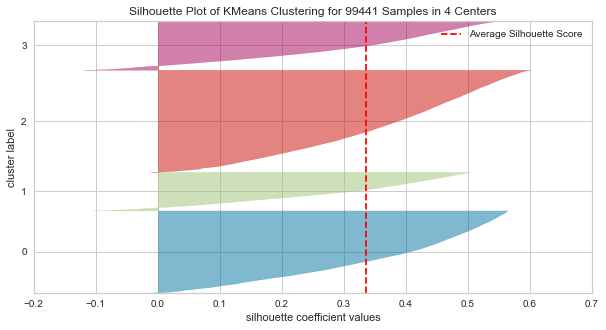

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 99441 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

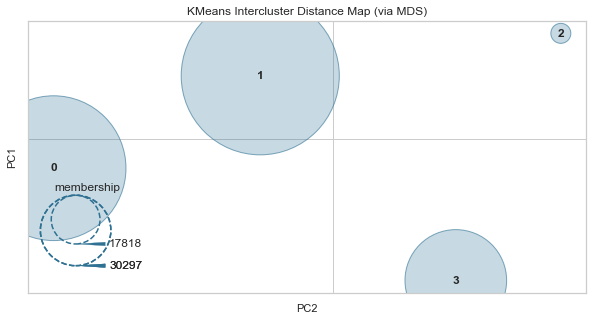

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [16]:
intercluster_distance(KMeans(4, random_state=42), df_pca)

In [17]:
print("Silhouette Score:", silhouette_score(df_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(df_pca, label))

Silhouette Score: 0.3364475868676404
Score de Davies-Bouldin: 0.9270673388614069


Les clusters ne sont pas assez équilibrés et pas assez stable. On va continuer à chercher en utilisant plus de variables.

## 4. Calcul de cluster avec 5 variables <a class="anchor" id="chapter4"></a>

### 4.1 Création des colonnes <a class="anchor" id="section_4_1"></a>

On va construire un nouveau cluster avec des variables supplémentaires. On va utiliser la distance d'haversine pour calculer la distance entre les clients et les acheteurs. La deuxième variable que l'on va ajouter et le nombre de jours de la livraison.<br>
Pour calculer la distance vendeurs-clients, on va construire un tableau. On va prendre la longitude et la latitude des vendeurs-clients et ensuite on calculera les clusters.<br>
On a déjà la longitude et la latitude des clients, on rajoutera celles des vendeurs.

In [18]:
data_sel = pd.read_csv("olist_sellers_dataset.csv")

df_sel = pd.merge(data_sel, data[['geolocation_lng', 'geolocation_lat', 'seller_id']], on = 'seller_id', how = "outer")
df_sel.columns = ["seller_id", "seller_zip_code_prefix", "seller_city", "seller_state",
                      "sel_geolocation_lng", "sel_geolocation_lat"]
df_sel.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-46.677754,-23.667671
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-44.035239,-19.961706
2,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-43.206503,-22.923410


In [19]:
df_sel.drop_duplicates("seller_id", inplace=True)

In [20]:
data_1 = pd.merge(data, df_sel, on = 'seller_id', how = "outer")
data_1.head(3)

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,...,R,F,M,RFM Score,Segment,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat
0,3ef8c1513fc80fb905ccd8d57da5e9b8,sao paulo,-23.545621,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.639292,books_technical,2018-08-21 17:51:40.000000000,2018-08-18 03:09:46.000000000,61.0,1.0,...,5.0,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621
1,cb382a3e0fbce8a1d31e86f807314dc8,sao paulo,-23.640619,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.696566,books_technical,2018-08-21 18:12:52.000000000,2018-08-18 02:49:48.000000000,61.0,1.0,...,5.0,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621
2,40b5e9eed4db7f956359145971056f5d,sao paulo,-23.738264,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.701857,books_technical,2018-08-16 21:38:54.000000000,2018-08-14 04:30:21.000000000,64.0,1.0,...,5.0,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621


In [21]:
tauxRemplissage(data_1)

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,...,R,F,M,RFM Score,Segment,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat
0,0.999899,0.999899,0.999899,1.0,0.999899,0.999899,0.999899,0.999899,0.999899,0.999899,...,0.999899,0.999899,0.999899,0.999899,0.999899,1.0,1.0,1.0,0.999899,0.999899


In [22]:
data_1[data_1["customer_unique_id"].isna()]

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,...,R,F,M,RFM Score,Segment,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat
99441,NaN,NaN,NaN,c240c4061717ac1806ae6ee72be3533b,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20920,rio de janeiro,RJ,NaN,NaN
99442,NaN,NaN,NaN,0336182e1b3e92f029d5354832045fdf,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14940,ibitinga,SP,NaN,NaN
99443,NaN,NaN,NaN,9d213f303afae4983637247556438ede,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14940,ibitinga,SP,NaN,NaN
99444,NaN,NaN,NaN,204b4e07bddef3c9b317f70189135b22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37564,borda da mata,MG,NaN,NaN
99445,NaN,NaN,NaN,e0b162a693bc7f9eab00f783a31d60ea,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,96020,pelotas,RS,NaN,NaN
99446,NaN,NaN,NaN,9315e491484b1b0081ca166fc164108d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,86039,londrina,PR,NaN,NaN
99447,NaN,NaN,NaN,1fa2d3def6adfa70e58c276bb64fe5bb,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4106,sao paulo,SP,NaN,NaN
99448,NaN,NaN,NaN,43a5d4a57af536fddc96d08be3afdfcb,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37006,varginha,MG,NaN,NaN
99449,NaN,NaN,NaN,0b09101900100c0e9d312861fad5a1b9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3168,sao paulo,SP,NaN,NaN
99450,NaN,NaN,NaN,5415337f1863452476d42d9f14a16a61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30840,belo horizonte,MG,NaN,NaN


In [23]:
data_1.drop(index = [99441, 99442, 99443, 99444, 99445, 99446, 99447, 99448, 99449, 99450], axis = 0, inplace = True)

In [24]:
data_1["dist_haversine"] = haversine_vectorize(data_1["geolocation_lat"], data_1["geolocation_lng"],\
                                         data_1["sel_geolocation_lat"], data_1["sel_geolocation_lng"])
    
data_1.head(3)

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,...,F,M,RFM Score,Segment,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat,dist_haversine
0,3ef8c1513fc80fb905ccd8d57da5e9b8,sao paulo,-23.545621,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.639292,books_technical,2018-08-21 17:51:40.000000000,2018-08-18 03:09:46.000000000,61.0,1.0,...,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,0.000000
1,cb382a3e0fbce8a1d31e86f807314dc8,sao paulo,-23.640619,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.696566,books_technical,2018-08-21 18:12:52.000000000,2018-08-18 02:49:48.000000000,61.0,1.0,...,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,9.642919
2,40b5e9eed4db7f956359145971056f5d,sao paulo,-23.738264,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.701857,books_technical,2018-08-16 21:38:54.000000000,2018-08-14 04:30:21.000000000,64.0,1.0,...,1.0,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,16.251862


In [25]:
time = ["order_approved_at", "order_delivered_customer_date"]

for cols in time:
    data_1[cols] = pd.to_datetime(data_1[cols],
                              format="%Y-%m-%d", errors="ignore")

In [26]:
data_1["nb_days_delivered"] = data_1["order_delivered_customer_date"] - data_1["order_approved_at"]
data_1["nb_days_delivered"] = data_1["nb_days_delivered"].dt.days

In [27]:
data_1 = data_1[data_1["nb_days_delivered"] > 0]
data_1.head(3)

,customer_unique_id,customer_city,geolocation_lat,seller_id,geolocation_lng,product_category_name_english,order_delivered_customer_date,order_approved_at,Recency,Frequency,...,M,RFM Score,Segment,seller_zip_code_prefix,seller_city,seller_state,sel_geolocation_lng,sel_geolocation_lat,dist_haversine,nb_days_delivered
0,3ef8c1513fc80fb905ccd8d57da5e9b8,sao paulo,-23.545621,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.639292,books_technical,2018-08-21 17:51:40,2018-08-18 03:09:46,61.0,1.0,...,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,0.000000,3
1,cb382a3e0fbce8a1d31e86f807314dc8,sao paulo,-23.640619,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.696566,books_technical,2018-08-21 18:12:52,2018-08-18 02:49:48,61.0,1.0,...,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,9.642919,3
2,40b5e9eed4db7f956359145971056f5d,sao paulo,-23.738264,2953ce3a88f5e3c3b696d77fc9e4c8eb,-46.701857,books_technical,2018-08-16 21:38:54,2018-08-14 04:30:21,64.0,1.0,...,1.0,511.0,new customers,4270,sao paulo,SP,-46.639292,-23.545621,16.251862,2


### 4.2 ACP <a class="anchor" id="section_4_2"></a>

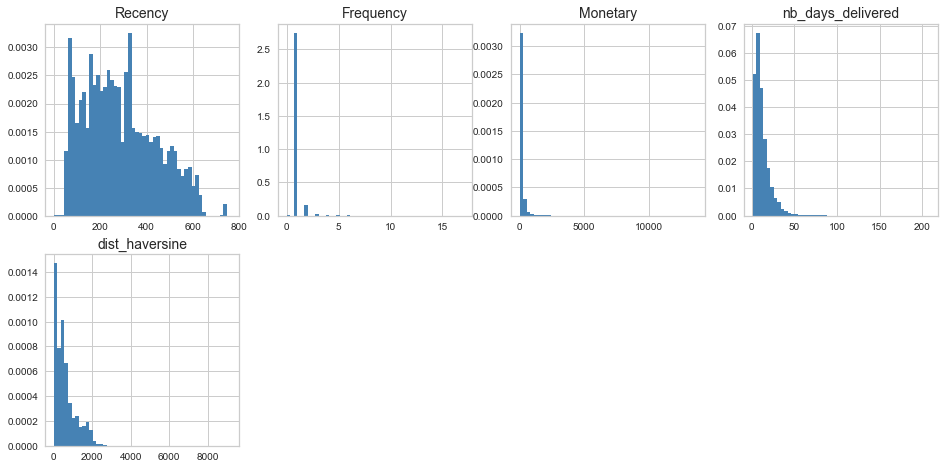

In [28]:
var = data_1[["Recency","Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]]
val = var.values

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(var.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(val[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var.columns[feat_idx], fontsize=14)

In [29]:
df1 = data_1[["customer_unique_id", "Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]].copy()
df1.set_index("customer_unique_id", inplace=True)
df1 = np.log1p(df1[["Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]])

In [30]:
scaler = StandardScaler()

scaler.fit(df1)
df1_norm = scaler.transform(df1)

In [31]:
n_comp = 2 #Nombre de dimension
pca_1 = PCA(n_components = n_comp)
features_1 = df1.columns
df1_pca = pca_1.fit_transform(df1_norm)
pcs_1 = pca_1.components_

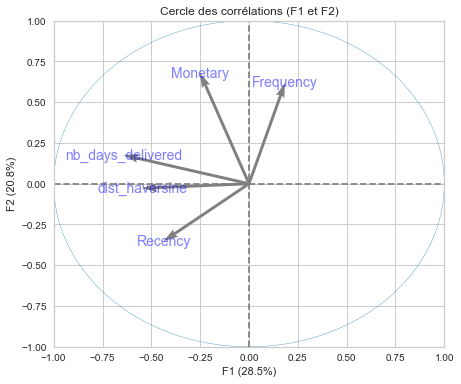

In [32]:
display_circles(pcs_1, n_comp, pca_1, [(0,1)], labels = np.array(features_1))

### 4.3 Clusters <a class="anchor" id="section_4_3"></a>

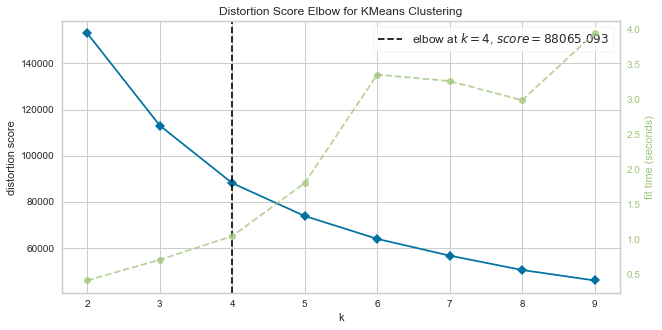

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans()
plt.rcParams["figure.figsize"] = (10,5)
visualizer = KElbowVisualizer(model, k =(2, 10))
visualizer.fit(df1_pca)
visualizer.show()

Text(0.5, 1.0, 'Représentation des clusters du K-Means')

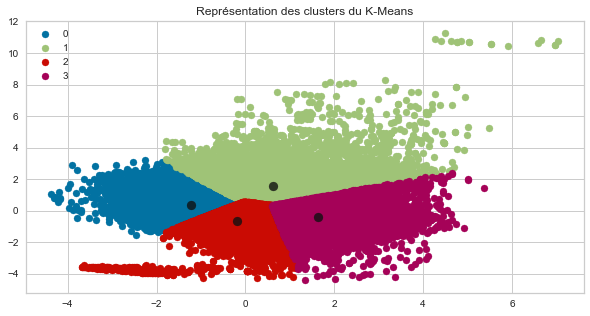

In [34]:
km = KMeans(n_clusters = 4)
label = km.fit_predict(df1_pca)

centroids = km.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df1_pca[label == i , 0] , df1_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')

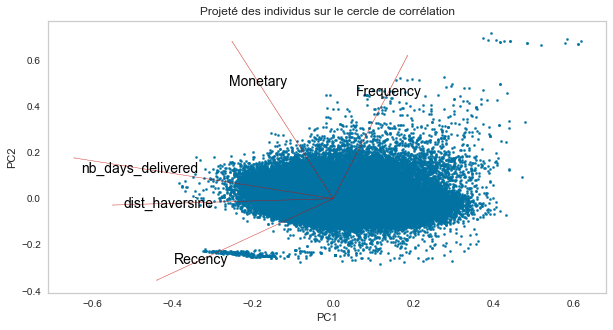

In [35]:
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0] * 0.75, coeff[i,1] * 0.75, "Var"+str(i+1),\
                     color = 'black', ha = 'center', va = 'center', fontsize=14)
        else:
            plt.text(coeff[i,0] * 0.75, coeff[i,1] * 0.75, labels[i],\
                     color = 'black', ha = 'center', va = 'center', fontsize=14)
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

myplot(df1_pca[:,0:2], np.transpose(pcs_1[0:2, :]), list(df1.columns))
plt.title('Projeté des individus sur le cercle de corrélation')
plt.show()

Avec les deux graphiques des clusters, on peut voir les clusters qui se regroupent. La "Monetary" avec la "Frequency", le temps de livraison et la distance, la récence.<br>
Le cluster 0 (bleu) : représente la distance et le temps de livraison.<br>
Le cluster 1 (vert) : n'est pas représenté par de flèches.<br>
Le cluster 2 (rouge) : représente la récence.<br>
Le cluster 3 (magenta) : représente la fréquence et le monétaire.<br>
Nos données sont bien représentées, les flèches sont grandes.

In [36]:
df1.reset_index(inplace = True)

pred = km.predict(df1_pca)
clusters = pd.DataFrame(pred, index=df1["customer_unique_id"]).reset_index()
clusters.columns = ["customer_unique_id", "Clusters"]
df1 = pd.merge(df1, clusters, on = "customer_unique_id")

In [37]:
df1["Clusters"].value_counts()

2    37238
0    28333
1    20984
3    20508
Name: Clusters, dtype: int64

In [38]:
df1.groupby('Clusters').mean().round(2)

,Recency,Frequency,Monetary,nb_days_delivered,dist_haversine
Clusters,,,,,
0,5.73,0.70,5.20,2.94,6.53
1,5.11,1.03,5.13,2.28,5.05
2,5.74,0.69,4.28,2.33,5.91
3,5.07,0.71,4.24,1.63,3.90


<AxesSubplot:xlabel='Clusters'>

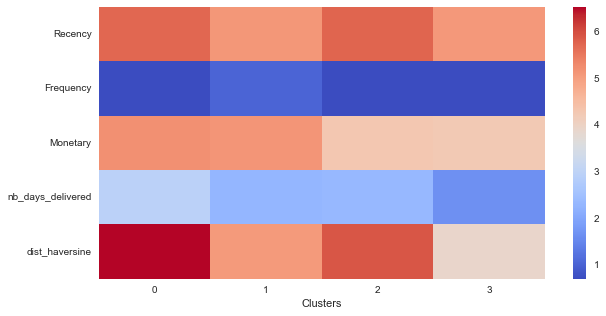

In [39]:
df_float = df1.groupby('Clusters').mean().round(2).transpose()

sns.heatmap(df_float, cmap = 'coolwarm')

Le cluster 0 : ont une récence élevé, payent peu, distance élévé. Objectif mail et publicité des produits moins chers.<br>
Le cluster 1 : moins de récence, peu cher, distance moyenenemnt élevé. Publicité de la ville et mail produit moins chers.<br>
Le cluster 2 : récence basse, produit plus cher et distance élevé. Publicité mail et produit plus cher.<br>
Le cluster 3 : récence élevé, produit cher, distance très elévé. Relance de mail sur des produits cher.

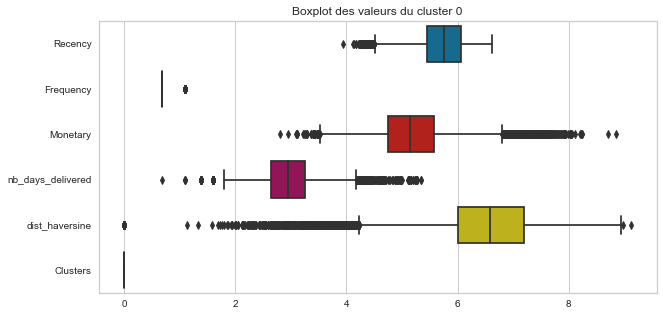

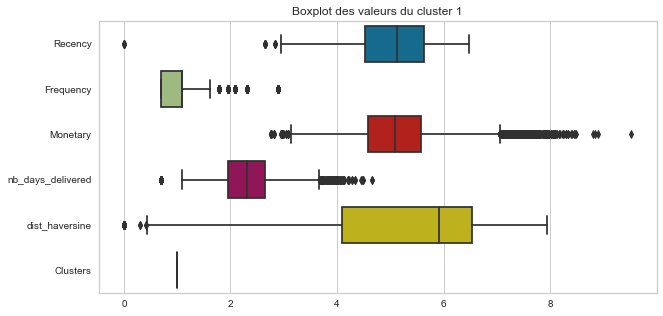

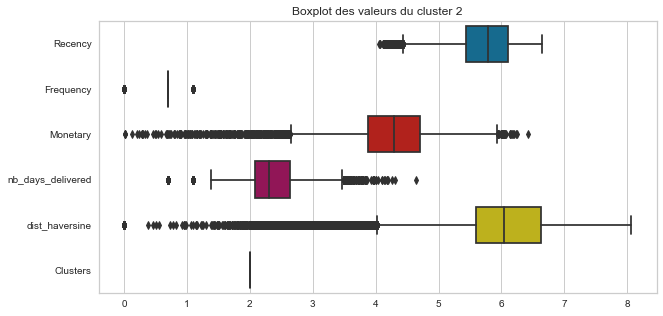

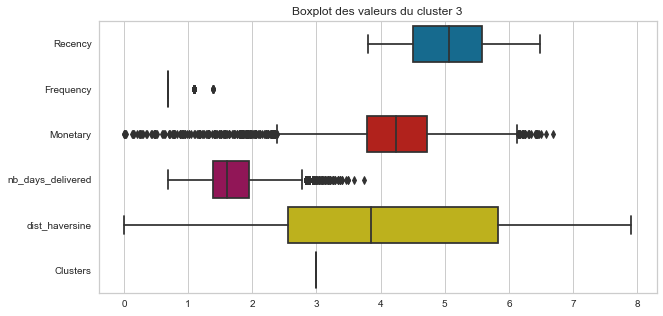

In [40]:
for i in range(0, 4, 1) :
    df1_0 = df1[df1["Clusters"] == i].select_dtypes(exclude = 'object')

    colonne = df1_0.columns

    sns.boxplot(data = df1_0.loc[:,colonne], orient = 'h')
    plt.title("Boxplot des valeurs du cluster "+ str(i))
    plt.show()

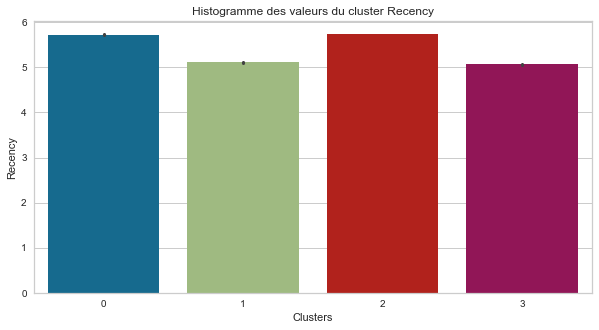

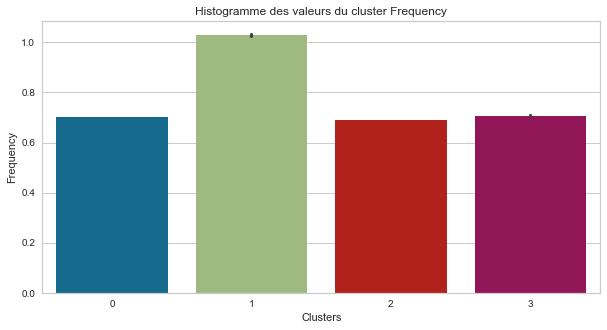

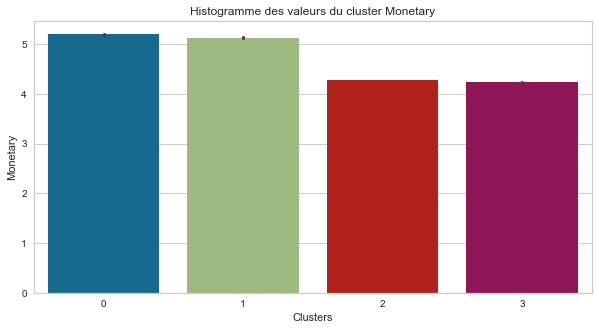

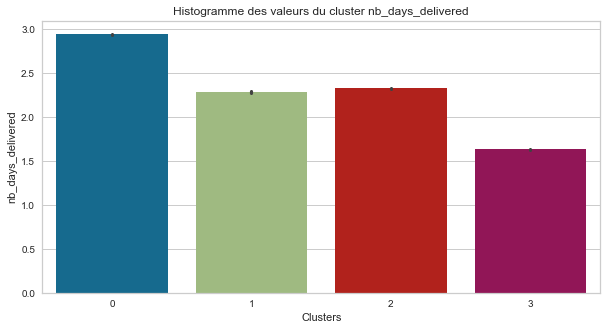

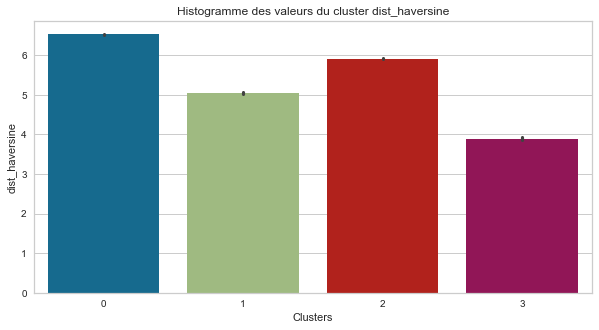

In [41]:
colors = ['b', 'g', 'r', 'm']
cols = ["Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]
for col in cols :
    sns.barplot(data = df1, x = "Clusters", y = col, palette = colors)
    plt.title("Histogramme des valeurs du cluster "+ col)
    plt.show()

Après qu'on ait vu la stabilité, on va examiner les clusters de plus près et les regarder dans un nuage de points. On va afficher les graphes :
- Monaitaire et Fréquence,
- Monaitaire et Récence,
- Monaitaire et nombre de jour de livraison,
- Monaitaire et la distance,
- La distance et le nombre de jour,
- La distance et la récence.

Text(0.5, 1.0, 'Nuage de points de la distance par rapport à la récence selon les clusters')

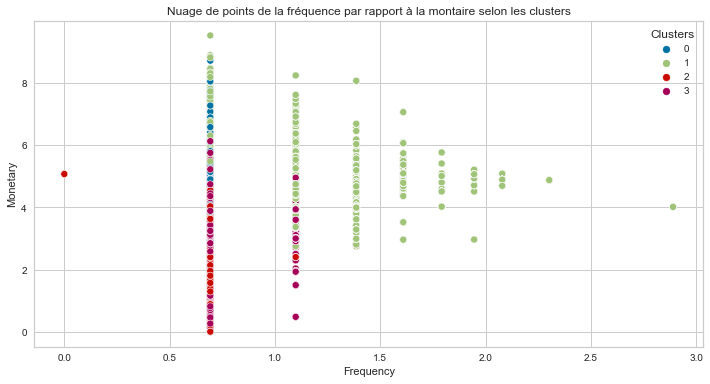

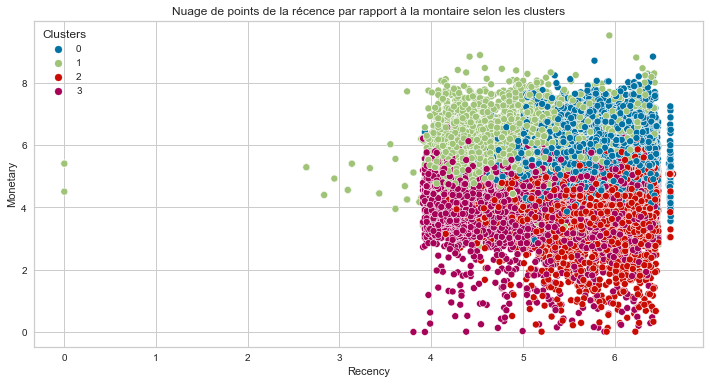

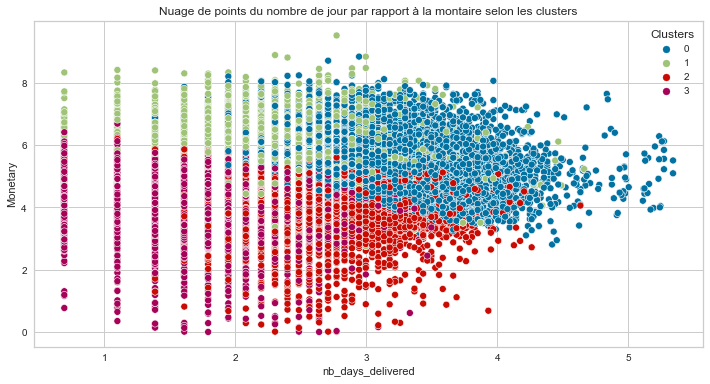

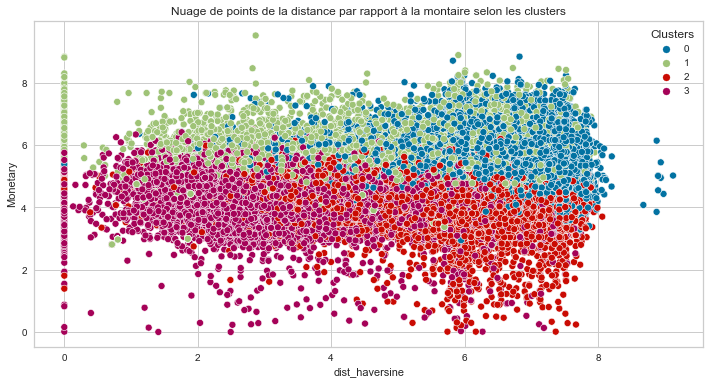

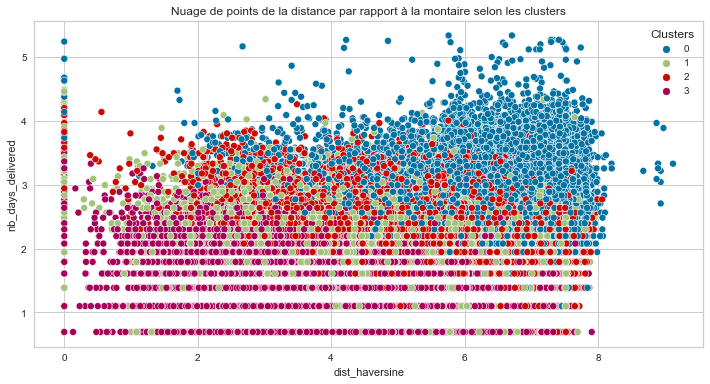

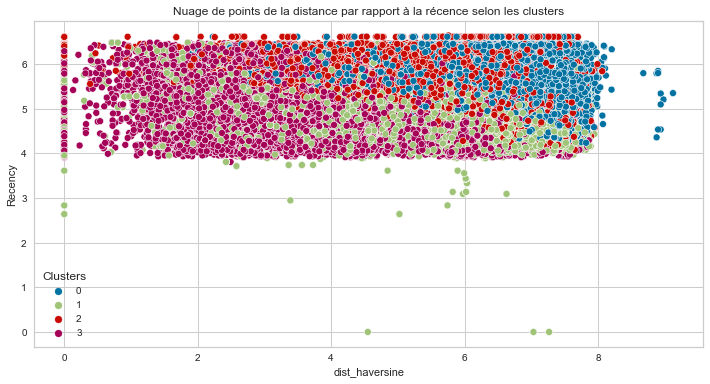

In [42]:
colors = ['b', 'g', 'r', 'm']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="Frequency", y="Monetary", hue="Clusters", palette = colors)
plt.title('Nuage de points de la fréquence par rapport à la montaire selon les clusters')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="Recency", y="Monetary", hue="Clusters", palette = colors)
plt.title('Nuage de points de la récence par rapport à la montaire selon les clusters')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="nb_days_delivered", y="Monetary", hue="Clusters", palette = colors)
plt.title('Nuage de points du nombre de jour par rapport à la montaire selon les clusters')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="dist_haversine", y="Monetary", hue="Clusters", palette = colors)
plt.title('Nuage de points de la distance par rapport à la montaire selon les clusters')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="dist_haversine", y="nb_days_delivered", hue="Clusters", palette = colors)
plt.title('Nuage de points de la distance par rapport à la montaire selon les clusters')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="dist_haversine", y="Recency", hue="Clusters", palette = colors)
plt.title('Nuage de points de la distance par rapport à la récence selon les clusters')

1 graphique : On voit que le cluster 2 (rouge, récence) achète fréquement.<br>
2 graphique : Le cluster 0 (bleu, dist et nb jour) achètent souvent et chère, le cluster 2 (rouge, récence) achètent moins souvent, le cluster 3 (mahenta, fréquence et le monétaire) achètent moins cher, mais souvent. Le cluster 1 (vert) achètent moins cher et ont une fréquence basse. Ils représnetent les mauvais clients.<br>
La conclusion : Le cluster 0 (bleu) et 2 (rouge, récence) sont les bons clients et le cluster 1 (vert) et le cluster 3 (magenta) représentent les moins bons clients.<br>
3 graphique : Temps de livraison par rapport au prix, faire en sorte de livrer le plus vite possible, mais 5 jours restent bons.<br>
4 graphique : le cluster 2 (rouge, récence) s'étend sur le cluster 0 (bleu) et le cluster 1 (vert) s'étend sur le cluster 3 (magenta). Les deux groupes achètent indifférement par rapport à position du client, même si on peut voir une tendance du cluster 0 (bleu) achètent plus loin que le cluster 2 (rouge) de même que le cluster 3 (magenta) par rapport au cluster 1 (vert).<br>
5 graphique : le cluster 1 (vert) achètent quelque soit la distance selon les vendeurs et les client 0 achètent chez les vendeurs éloignés. Les autres clusters sont éparpillés. Le vert achètent des produits moins chez, donc ils seront plus rapidement livrés.<br>
6 graphique : le temps entre chaque paimenent et la distance, les clusters sont éparpillées.<br>
Le cluster 2 (rouge) est un bon client, le 0 (bleu) peut être de bon client, le 3 (magenta) est client moyen et le cluster 1 (vert) est un moins bon clients.

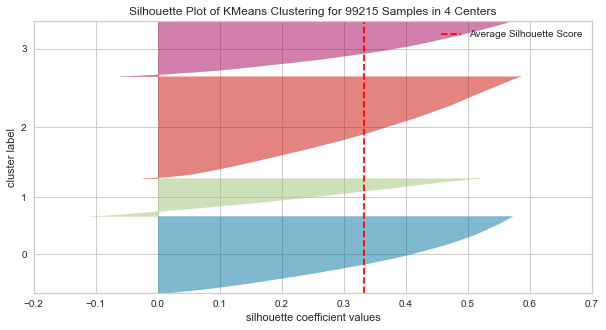

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 99215 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df1_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

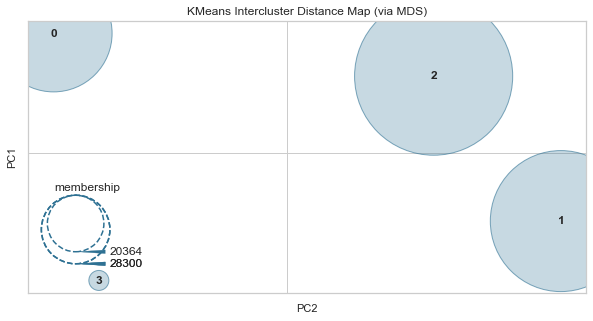

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [44]:
intercluster_distance(KMeans(4, random_state=42), df1_pca)

Ce modèle des 5 variables semble stable. On gardera ces 5 variables par la suite.

In [45]:
print("Silhouette Score:", silhouette_score(df1_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(df1_pca, label))

Silhouette Score: 0.33284579788575824
Score de Davies-Bouldin: 0.9439730332672305


### 4.4 t-SNE et DBSCAN <a class="anchor" id="section_4_4"></a>

Maintenant, nous allons faire un autre test avec une autre méthode. Pour choisir la meilleure méthode, on va effectuer une réduction de dimension avec t-SNE et un clustering avec le DBSCAN.<br>
t-SNE est un outil pour visualiser des données de grande dimension. Il convertit les similitudes entre les points de données, on utilise ACP pour réduire les dimensions.<br>
DBSCAN permet un regroupement spatial basé sur la densité d'applications avec bruit.

In [46]:
df1 = data_1[["customer_unique_id", "Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]].copy()
df1.set_index("customer_unique_id", inplace=True)
df1 = np.log1p(df1[["Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]])

methode = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12, n_iter=1000, learning_rate=368, verbose=1)
df1_tnse = methode.fit_transform(df1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99215 samples in 0.200s...
[t-SNE] Computed neighbors for 99215 samples in 7.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 99215
[t-SNE] Computed conditional probabilities for sample 2000 / 99215
[t-SNE] Computed conditional probabilities for sample 3000 / 99215
[t-SNE] Computed conditional probabilities for sample 4000 / 99215
[t-SNE] Computed conditional probabilities for sample 5000 / 99215
[t-SNE] Computed conditional probabilities for sample 6000 / 99215
[t-SNE] Computed conditional probabilities for sample 7000 / 99215
[t-SNE] Computed conditional probabilities for sample 8000 / 99215
[t-SNE] Computed conditional probabilities for sample 9000 / 99215
[t-SNE] Computed conditional probabilities for sample 10000 / 99215
[t-SNE] Computed conditional probabilities for sample 11000 / 99215
[t-SNE] Computed conditional probabilities for sample 12000 / 99215
[t-SNE] Computed conditional probabilities for sam

In [47]:
# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps = 4
get_clusters = DBSCAN(eps = 4, min_samples = 10).fit_predict(df1_tnse)

In [48]:
set(get_clusters)

{0, 1}

Text(0.5, 1.0, 'Représentation des clusters du K-Means')

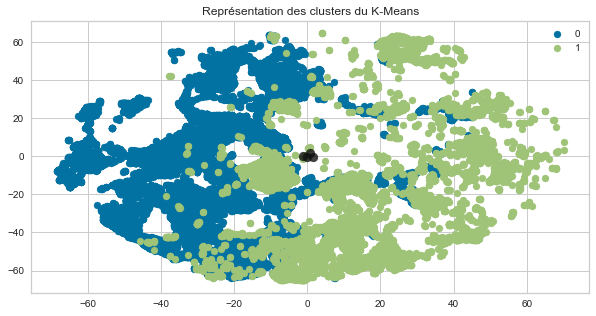

In [49]:
u_labels = np.unique(get_clusters)
for i in u_labels:
    plt.scatter(df1_tnse[label == i , 0] , df1_tnse[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')

In [50]:
print("Silhouette Score:", silhouette_score(df1_tnse, get_clusters))
print("Score de Davies-Bouldin:", davies_bouldin_score(df1_tnse, get_clusters))

Silhouette Score: 0.20255178
Score de Davies-Bouldin: 0.5935762605900399


In [51]:
# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps = 4
get_clusters = DBSCAN(eps = 4, min_samples = 100).fit_predict(df1_tnse)

In [52]:
set(get_clusters)

{0, 1}

Text(0.5, 1.0, 'Représentation des clusters du K-Means')

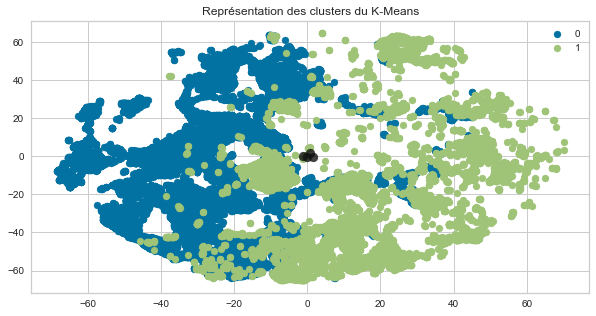

In [53]:
u_labels = np.unique(get_clusters)
for i in u_labels:
    plt.scatter(df1_tnse[label == i , 0] , df1_tnse[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')

In [54]:
print("Silhouette Score:", silhouette_score(df1_tnse, get_clusters))
print("Score de Davies-Bouldin:", davies_bouldin_score(df1_tnse, get_clusters))

Silhouette Score: 0.20255178
Score de Davies-Bouldin: 0.5935762605900399


In [55]:
# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps = 3
get_clusters = DBSCAN(eps = 3, min_samples = 100).fit_predict(df1_tnse)

In [56]:
set(get_clusters)

{-1, 0, 1, 2}

Text(0.5, 1.0, 'Représentation des clusters du K-Means')

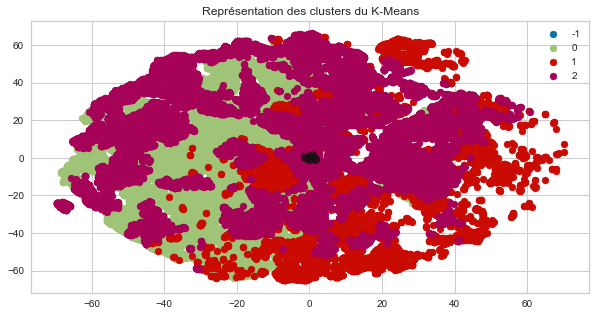

In [57]:
u_labels = np.unique(get_clusters)
for i in u_labels:
    plt.scatter(df1_tnse[label == i , 0] , df1_tnse[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')

In [58]:
print("Silhouette Score:", silhouette_score(df1_tnse, get_clusters))
print("Score de Davies-Bouldin:", davies_bouldin_score(df1_tnse, get_clusters))

Silhouette Score: -0.099636115
Score de Davies-Bouldin: 0.7053792439840819


Cette méthode est moins optimisé et moins stable que la première, par la suite, on utilisera l'autre méthode.

## 5. ARI <a class="anchor" id="chapter5"></a>

L'objectif maintenant est de déterminer au bout de combien de temps le cluster entraîné avec les cinq variables n'est plus pertinent et donc utiliser un nouveau modèle.<br>
Nous allons donc construire notre nouveau modèle M0 au temps T0. Le temps T0 est choisi en fin du fichier (31 décembre 2017), on utilise la méthode "StandarScaler" pour standardiser nos données. On calcule : "C0 = M0.fit(F0)".<br>
Puis on calcule T1, T2, ... ; tous les 15 jours, et notre calcule sera C1_new = M1.fit(F1) et C1_init = M0.predict(F1). Pour les comparer, on utilisera l'ARI. On affichera l'évolution ARI et si le score passe en dessous de 0.8, il sera pertinent de changer de modèle.<br>
<br>
Construction de nos tableaux selon une date, on commence par la construction du modèle M0.

In [59]:
def construction_F(an, mois, jour, heure, minute, seconde) :
    prov = datetime(an, mois, jour, heure, minute, seconde, 0)
    prov = pd.to_datetime(prov, format="%Y-%m-%d", errors="ignore")
    F = data_1[data_1["order_delivered_customer_date"] <= prov]
    F = F[["customer_unique_id", "Recency", "Frequency", "Monetary", "nb_days_delivered", "dist_haversine"]].copy()
    F.set_index("customer_unique_id", inplace=True)
    return F

In [60]:
F0 = construction_F(2017, 12, 31, 23, 59, 59)

On fait la standardisation et la construction du modèle.

In [61]:
scaler = StandardScaler()

scaler.fit(F0)
F0_norm = scaler.transform(F0)

M0 = KMeans(n_clusters = 4)

C0 = M0.fit_transform(F0_norm)

Construction des fichiers.

In [62]:
F = []
for i in range(1,9) :
    F.append(construction_F(2018,i,1,23,59,59))
    F.append(construction_F(2018,i,15,23,59,59))

Test d'ARI.

In [63]:
def test_ARI(F1) :
    scaler = StandardScaler()

    scaler.fit(F1)
    F1_norm = scaler.transform(F1)

    M1 = KMeans(n_clusters = 4)

    C1_new = M1.fit_transform(F1_norm)

    C1_new_test = M1.predict(F1_norm)

    C1_init = scaler.transform(F1)
    C1_init = M0.predict(C1_init)

    return adjusted_rand_score(C1_new_test, \
                          C1_init)

In [64]:
ari = []
for i in range(0, len(F), 1) :
    ari.append(test_ARI(F[i]))

C:\Users\cisso\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\cisso\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\cisso\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\cisso\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\cisso\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\Users\ci

In [65]:
tab = pd.DataFrame(ari)
tab.reset_index(inplace = True)

In [66]:
mois = ["Janvier_1", "Janvier_15", "Février_1", "Février_15", "Mars_1", "Mars_15", "Avril_1",\
        "Avril_15", "Mai_1", "Mai_15", "Juin_1", "Juin_15", "Juillet_1", "Juillet_15", "Aout_1", "Aout_15"]

In [67]:
tab.rename(columns={"index" : "Mois", 0 : "ARI"}, inplace = True)

In [68]:
for i in range(0, len(tab), 1) :
    tab["Mois"][i] = mois[i]

C:\Users\cisso\AppData\Local\Temp/ipykernel_16360/2009807533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab["Mois"][i] = mois[i]
C:\Users\cisso\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[(0.6, 1.1)]

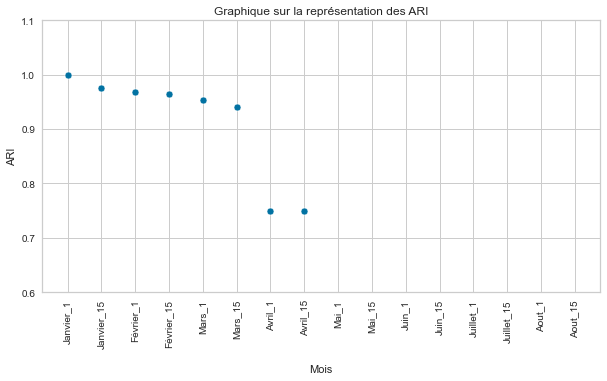

In [69]:
fig,ax = plt.subplots()
g = sns.scatterplot(data = tab, x = "Mois", y = "ARI")
plt.xlabel('\nMois')
plt.ylabel("ARI")
plt.title("Graphique sur la représentation des ARI")
ax.tick_params(axis='x', rotation=90)
g.set(ylim=(0.6, 1.1))

Notre modèle date du 31/12/2018 et notre modèle passe en dessous du score (inférieur à 0.8) en avril. Il faudra changer nos modèles pour les mois suivants. On va créer un nouveau modèle au mois d'avril.

## 6. Conclusion <a class="anchor" id="chapter6"></a>

Nous avons plusieurs types de clients, ce qui achète souvent et beaucoup, pour les garder, envoyer de la publicité cible. Pour les clients qui payent souvent, mais des produits moins chers. La publicité ciblée pour qu'il continue d'acheter.<br>
Ceux qui achètent une fois et ne renouvellent pas.<br>
Mettre en avant les produits cosmétiques et de la salle de bain, permettre des livraisons rapides pour continuer de garder des clients et continuer d'avoir une bonne fréquence des achats.<br>
<br>
Notre modèle marche tous les trois mois, la prochaine étude devrait se faire en avril, la prochaine sera en août.